In [1]:
import scipy.stats as stats
from scipy.stats import wilcoxon, kruskal
import scikit_posthocs as sp
import pandas as pd
import xlrd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from scikit_posthocs import posthoc_dunn
import numpy as np

In [2]:
test_results = pd.read_excel("C:\\Users\\MERVE EKİZ\\Downloads\\wandb_test_results_for_english.xlsx")

In [3]:
test_results.head()

,model,user_input,context_recall,non_llm_context_precision_with_reference,factual_correctness,faithfulness,semantic_similarity
0,model1,question1,0.75,0.250000,0.38,0.290323,0.925462
1,model1,question2,1.00,0.000000,0.24,0.750000,0.906159
2,model1,question3,1.00,1.000000,0.75,0.800000,0.972465
3,model1,question4,1.00,0.916667,0.80,1.000000,0.972109
4,model1,question5,0.00,0.000000,0.08,0.000000,0.937651


In [4]:
# define metrics 
all_metrics = [
    "context_recall",
    "non_llm_context_precision_with_reference",
    "factual_correctness",
    "faithfulness",
    "semantic_similarity",
]

In [5]:
# group data for each model
grouped_data = test_results.groupby("model")

### Kruskal-Wallis Test

In [6]:
kruskal_results = {}
for metric in all_metrics:
    data_per_model = [group[metric].dropna().values for name, group in grouped_data]
    kruskal_results[metric] = kruskal(*data_per_model)

In [7]:
kruskal_results

{'context_recall': KruskalResult(statistic=np.float64(13.029981046073924), pvalue=np.float64(0.16125433813813433)),
 'non_llm_context_precision_with_reference': KruskalResult(statistic=np.float64(34.19076314124592), pvalue=np.float64(8.269954462036544e-05)),
 'factual_correctness': KruskalResult(statistic=np.float64(14.273470841023496), pvalue=np.float64(0.11292446362395579)),
 'faithfulness': KruskalResult(statistic=np.float64(14.95037387056292), pvalue=np.float64(0.09230817208591681)),
 'semantic_similarity': KruskalResult(statistic=np.float64(11.307978320985061), pvalue=np.float64(0.2551878706957111))}

Kruskal - Wallis Test Results:
As it is seen from the code above, onyl non-llm context precision with reference metric has a significant difference among models because the p-value is less than 0.05 for this metric. 

1. Semantic Similarity: 
𝑝>0.05
There is no significant differences among models.
2. Factual Correctness: 
𝑝>0.05
There is no significant differences among models.
3. Context Recall:  
𝑝>0.05
There is no significant differences among models.
4. Non-LLM Context Precision with Reference:
p<0.05
Significant differences exist among models.
5. Faithfulness:
𝑝>0.05
There is no significant differences among models.


#### Dunn's Test to compare all pairwise differences between groups

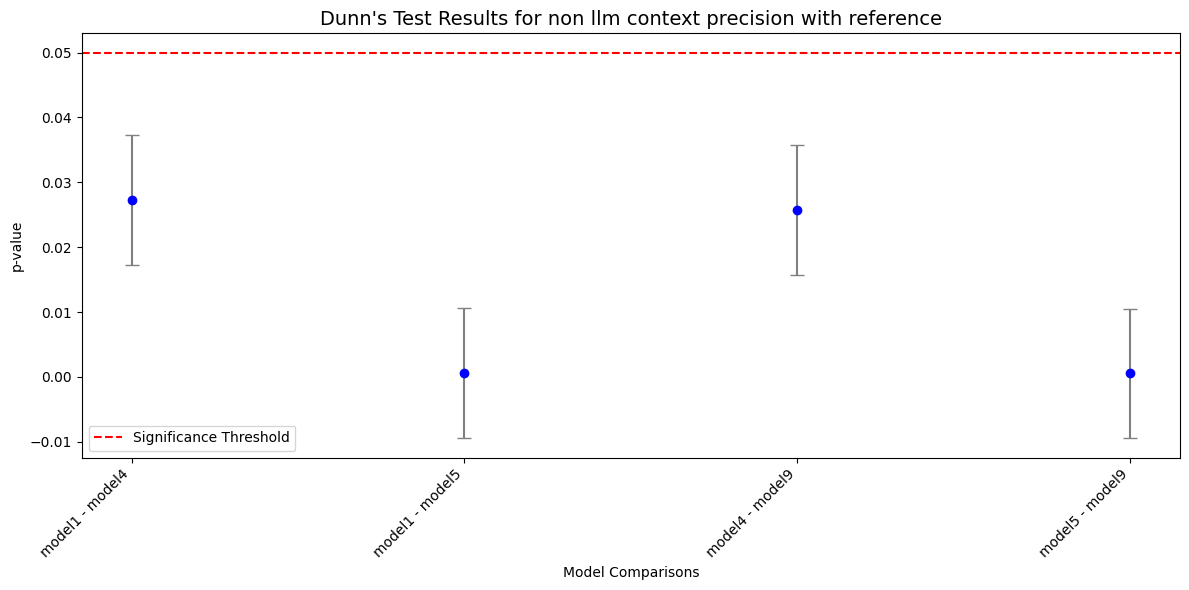

In [8]:
# Perform Dunn's test
dunn_results = posthoc_dunn(
    test_results, val_col="non_llm_context_precision_with_reference", group_col="model", p_adjust="bonferroni"
)

# Extract significant comparisons
significant_pairs1 = [
    (row, col, p_value)
    for row, series in dunn_results.iterrows()
    for col, p_value in series.items()
    if row < col and p_value < 0.05
]

# Prepare visualization data
x_labels = []
x_values = []
y_errors = []

for i, (model1, model2, p_value) in enumerate(significant_pairs1):
    x_labels.append(f"{model1} - {model2}")
    x_values.append(p_value) 
    y_errors.append(0.01)  # Placeholder error bars

# Plot the results
plt.figure(figsize=(12, 6))
plt.errorbar(x_labels, x_values, yerr=y_errors, fmt='o', color='blue', ecolor='gray', capsize=5)
plt.axhline(0.05, color='red', linestyle='--', label="Significance Threshold")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Model Comparisons")
plt.ylabel("p-value")
plt.title(f"Dunn's Test Results for non llm context precision with reference", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

### One-sided Wilcoxon signed-rank test to find the statistically higher performance

In [9]:
# Filter data for Wilcoxon signed-rank test
metric_data = test_results[["model", "non_llm_context_precision_with_reference"]].dropna()

# Prepare pairwise comparisons for one-sided Wilcoxon tests
pairwise_results = []

for model1, model2 in itertools.combinations(test_results["model"].unique(), 2):
    data1 = metric_data.loc[metric_data["model"] == model1, "non_llm_context_precision_with_reference"].values
    data2 = metric_data.loc[metric_data["model"] == model2, "non_llm_context_precision_with_reference"].values
    
    # Ensure paired comparison by matching lengths
    min_len = min(len(data1), len(data2))
    data1, data2 = data1[:min_len], data2[:min_len]
    
    # Perform one-sided Wilcoxon test 
    stat, p_value = wilcoxon(data1, data2, alternative='greater')
    pairwise_results.append((model1, model2, stat, p_value))

# Filter significant results
significant_results = [(m1, m2, stat, p) for m1, m2, stat, p in pairwise_results if p < 0.05]

# Display significant one-sided Wilcoxon test results
significant_results

[('model2', 'model9', np.float64(742.5), np.float64(0.0018964852114972772)),
 ('model3', 'model9', np.float64(662.5), np.float64(0.004065111743744949)),
 ('model4', 'model9', np.float64(637.0), np.float64(7.966861166277368e-06)),
 ('model5', 'model6', np.float64(585.0), np.float64(0.0009297464365598015)),
 ('model5', 'model7', np.float64(430.5), np.float64(0.003653959377403684)),
 ('model5', 'model8', np.float64(446.5), np.float64(0.005404332413877948)),
 ('model5', 'model9', np.float64(929.5), np.float64(1.5151058791519687e-06)),
 ('model5', 'model10', np.float64(325.0), np.float64(0.002659347564162181)),
 ('model6', 'model9', np.float64(638.5), np.float64(0.0010498676848276246)),
 ('model7', 'model9', np.float64(430.0), np.float64(0.00017604564010862203)),
 ('model8', 'model9', np.float64(528.0), np.float64(3.942098592199212e-05))]

In [10]:
mean_metric = (
    test_results.groupby("model")["non_llm_context_precision_with_reference"].mean().sort_values(ascending=False)
)

mean_metric

model
model5     0.654535
model4     0.589368
model8     0.532414
model10    0.531746
model2     0.524439
model6     0.514853
model7     0.514651
model3     0.507048
model1     0.332048
model9     0.323961
Name: non_llm_context_precision_with_reference, dtype: float64

Mean of All Metrics

In [26]:
mean_metric = (
    test_results.groupby("model")["context_recall"].mean().sort_values(ascending=False)
)

mean_metric

model
model6     0.830335
model5     0.791478
model4     0.788813
model7     0.764739
model8     0.747058
model10    0.712177
model2     0.681185
model9     0.678159
model1     0.677828
model3     0.659259
Name: context_recall, dtype: float64

In [27]:
mean_metric = (
    test_results.groupby("model")["non_llm_context_precision_with_reference"].mean().sort_values(ascending=False)
)

mean_metric

model
model5     0.654535
model4     0.589368
model8     0.532414
model10    0.531746
model2     0.524439
model6     0.514853
model7     0.514651
model3     0.507048
model1     0.332048
model9     0.323961
Name: non_llm_context_precision_with_reference, dtype: float64

In [28]:
mean_metric = (
    test_results.groupby("model")["factual_correctness"].mean().sort_values(ascending=False)
)

mean_metric

model
model10    0.468413
model5     0.466190
model6     0.455079
model8     0.440794
model4     0.437143
model7     0.422222
model1     0.386349
model2     0.362787
model3     0.360794
model9     0.357143
Name: factual_correctness, dtype: float64

In [29]:
mean_metric = (
    test_results.groupby("model")["faithfulness"].mean().sort_values(ascending=False)
)

mean_metric

model
model6     0.751381
model5     0.695784
model2     0.680926
model7     0.676248
model8     0.660316
model4     0.659267
model3     0.626087
model1     0.622404
model10    0.593411
model9     0.570362
Name: faithfulness, dtype: float64

In [30]:
mean_metric = (
    test_results.groupby("model")["semantic_similarity"].mean().sort_values(ascending=False)
)

mean_metric

model
model10    0.934510
model8     0.933978
model5     0.933950
model4     0.933783
model7     0.931414
model9     0.930765
model1     0.926254
model6     0.921312
model3     0.892985
model2     0.891056
Name: semantic_similarity, dtype: float64